### Binary Classification

In [2]:
import sklearn 
from sklearn.datasets import make_circles
import pandas as pd
import torch
from torch import nn
from sklearn.metrics import accuracy_score 

In [ ]:
torch.is

In [126]:
n_samples = 1000

X,y = make_circles(n_samples,noise=0.03,random_state=42)

In [127]:
circle_dataset = pd.DataFrame({"X1":X[:,0],
                               "X2":X[:,1],
                               "y":y})
circle_dataset.head(5)

,X1,X2,y
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0


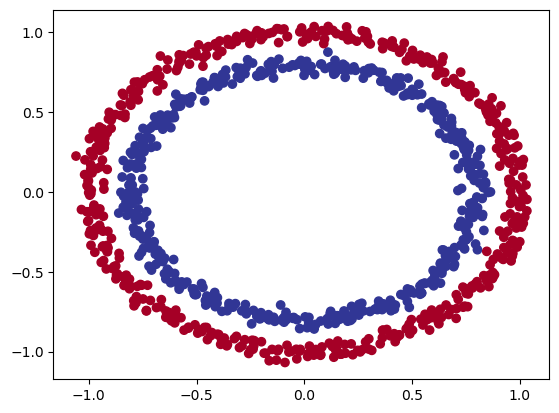

In [128]:
import matplotlib.pyplot as plt

plt.scatter(x=X[:,0],
            y=X[:,1],
            c=y,
            cmap=plt.cm.RdYlBu)

In [129]:
len(X),len(y)

(1000, 1000)

In [130]:
X.shape,y.shape

((1000, 2), (1000,))

In [131]:
from sklearn.model_selection import train_test_split

X_train,X_test,Y_train,Y_test = train_test_split(X,y,random_state=32,test_size=0.2)
len(X_train),len(X_test)
X_train = torch.tensor(X_train,dtype=torch.float)
Y_train = torch.tensor(Y_train,dtype=torch.float)
X_test = torch.tensor(X_test,dtype=torch.float)
Y_test = torch.tensor(Y_test,dtype=torch.float)


### Classification model

In [133]:
class CircleModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=2,out_features=8)
        self.layer_2 = nn.Linear(in_features=8,out_features=1)
        self.relu = nn.ReLU()

    def forward(self,x:torch.Tensor)->torch.Tensor:
        return self.layer_2(self.relu(self.layer_1(x)))

In [135]:
torch.manual_seed(3567982)
model = CircleModel()
model

CircleModel(
  (layer_1): Linear(in_features=2, out_features=8, bias=True)
  (layer_2): Linear(in_features=8, out_features=1, bias=True)
  (relu): ReLU()
)

In [136]:
model.state_dict()

OrderedDict([('layer_1.weight',
              tensor([[-0.5503, -0.3760],
                      [-0.1631,  0.4532],
                      [ 0.0518,  0.1463],
                      [ 0.5935, -0.0833],
                      [-0.3824, -0.1855],
                      [ 0.1435,  0.4652],
                      [ 0.1591,  0.5953],
                      [-0.2952,  0.2577]])),
             ('layer_1.bias',
              tensor([-0.0831,  0.2329, -0.2744,  0.4818,  0.5801,  0.4459,  0.4264,  0.0254])),
             ('layer_2.weight',
              tensor([[-0.1166, -0.0467, -0.2468, -0.3149, -0.2451,  0.3180,  0.2140,  0.0138]])),
             ('layer_2.bias', tensor([0.2964]))])

### Loss Function

In [138]:
loss_func = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(params=model.parameters(),lr=0.1)

In [139]:
def accuracy(y_true,y_pred):
    correct = torch.eq(y_true,y_pred).sum().item()
    acc = (correct/(y_pred))*100
    return acc         

In [140]:
X_train

tensor([[-0.2733, -0.7051],
        [ 0.4533,  0.8927],
        [ 0.8156,  0.1662],
        ...,
        [-0.0936, -0.8154],
        [ 0.3645, -0.7078],
        [-0.6709,  0.7247]])

In [141]:
model.eval()
with torch.inference_mode():
    y_logits = model(X_test)

y_logits[:10]

tensor([[ 0.0370],
        [ 0.5002],
        [ 0.2837],
        [-0.1053],
        [ 0.1270],
        [-0.0486],
        [ 0.2052],
        [-0.0846],
        [ 0.3415],
        [ 0.2151]])

In [143]:
y_prediction_one_liner = torch.round(torch.sigmoid(model(X_test))).squeeze()
y_prediction_one_liner[:5]

tensor([1., 1., 1., 0., 1.], grad_fn=<SliceBackward0>)

### training and testing loop

In [145]:
Y_train[:5]

tensor([1., 0., 1., 1., 1.])

In [166]:
%%time
epochs = 10000

epochs_count =[]
training_loss = []
testing_loss = []

for epoch in range(epochs):
    model.train()
    y_logits = model(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits))

    loss = loss_func(y_logits,Y_train)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    model.eval()
    with torch.inference_mode():
        test_preds = model(X_test)
        test_loss = loss_func(test_preds.squeeze(),Y_test)

    epochs_count.append(epoch)
    training_loss.append(loss)
    testing_loss.append(test_loss)
    accuracy_train = accuracy_score(Y_train,torch.round(torch.sigmoid(y_logits)).squeeze().detach().numpy())
    accuracy_test = accuracy_score(Y_test,torch.round(torch.sigmoid(test_preds)).squeeze().numpy())
    if epoch%1000==0:
        print(f"Epoch :{epoch} |Train Loss :{loss:.3f} | Train Accuracy {accuracy_train*100:.3f}% | Test loss {test_loss:.3f} | Test Accuracy {accuracy_test*100:.3f}%")


Epoch :0 |Train Loss :0.706 | Train Accuracy 52.625% | Test loss 0.693 | Test Accuracy 57.500%
Epoch :1000 |Train Loss :0.602 | Train Accuracy 89.125% | Test loss 0.610 | Test Accuracy 88.000%
Epoch :2000 |Train Loss :0.337 | Train Accuracy 98.875% | Test loss 0.352 | Test Accuracy 97.500%
Epoch :3000 |Train Loss :0.151 | Train Accuracy 99.875% | Test loss 0.165 | Test Accuracy 98.500%
Epoch :4000 |Train Loss :0.086 | Train Accuracy 99.875% | Test loss 0.099 | Test Accuracy 98.500%
Epoch :5000 |Train Loss :0.058 | Train Accuracy 100.000% | Test loss 0.070 | Test Accuracy 99.000%
Epoch :6000 |Train Loss :0.043 | Train Accuracy 100.000% | Test loss 0.055 | Test Accuracy 99.000%
Epoch :7000 |Train Loss :0.034 | Train Accuracy 100.000% | Test loss 0.047 | Test Accuracy 99.000%
Epoch :8000 |Train Loss :0.028 | Train Accuracy 100.000% | Test loss 0.041 | Test Accuracy 99.000%
Epoch :9000 |Train Loss :0.024 | Train Accuracy 100.000% | Test loss 0.036 | Test Accuracy 99.000%
CPU times: total: 

In [66]:
torch.round(torch.sigmoid(y_logits)).squeeze().detach().numpy()

array([0., 1., 0., 0., 1., 0., 1., 1., 0., 0., 1., 1., 0., 1., 1., 1., 1.,
       1., 0., 1., 1., 1., 1., 0., 1., 1., 0., 1., 0., 1., 0., 0., 0., 0.,
       0., 1., 1., 0., 1., 0., 0., 1., 1., 1., 0., 0., 1., 0., 0., 1., 0.,
       0., 0., 1., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1., 1., 0., 0., 0.,
       1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0.,
       0., 0., 0., 1., 0., 1., 1., 0., 0., 0., 1., 1., 1., 0., 1., 0., 0.,
       1., 1., 1., 1., 0., 1., 0., 1., 1., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 1., 0., 1., 0., 1., 0., 0.,
       0., 1., 1., 1., 0., 0., 1., 0., 1., 1., 1., 1., 0., 0., 1., 0., 0.,
       1., 1., 0., 0., 0., 1., 0., 1., 0., 0., 1., 0., 1., 0., 0., 0., 0.,
       0., 1., 1., 1., 1., 1., 0., 1., 1., 0., 0., 1., 1., 1., 0., 0., 1.,
       0., 1., 1., 1., 0., 0., 1., 1., 1., 1., 0., 1., 1., 0., 0., 1., 1.,
       1., 0., 1., 1., 1., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 0., 1.,
       1., 1., 1., 1., 0.

In [25]:
model.state_dict()

OrderedDict([('layer_1.weight',
              tensor([[-5.5043e-01, -3.7594e-01],
                      [-1.6298e-01,  4.5294e-01],
                      [ 5.1773e-02,  1.4631e-01],
                      [ 5.9385e-01, -8.3090e-02],
                      [-3.8239e-01, -1.8550e-01],
                      [ 1.4344e-01,  4.6514e-01],
                      [ 1.5909e-01,  5.9508e-01],
                      [-2.9529e-01,  2.5787e-01],
                      [-8.3155e-02,  2.3317e-01],
                      [-2.7431e-01,  4.8139e-01],
                      [ 5.8007e-01,  4.4584e-01],
                      [ 4.2636e-01,  2.5405e-02],
                      [-2.3331e-01, -9.3335e-02],
                      [-4.9369e-01, -6.2995e-01],
                      [-4.9036e-01,  6.3620e-01],
                      [ 4.2821e-01,  2.7622e-02],
                      [ 5.9292e-01,  3.1353e-01],
                      [-1.3842e-01, -6.0383e-01],
                      [ 2.5297e-01, -2.3102e-01],
                  

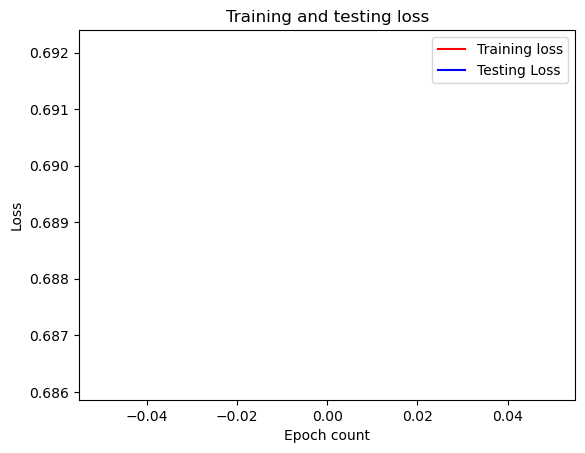

In [26]:

plt.plot(epochs_count,torch.tensor(training_loss).numpy(),c="r",label="Training loss")
plt.plot(epochs_count,torch.tensor(testing_loss).numpy(),c="b",label="Testing Loss")
plt.title("Training and testing loss")
plt.xlabel("Epoch count")
plt.ylabel("Loss")
plt.legend()
plt.show()